In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

In [2]:
#Hyperparameter tuning
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

#Load preprocessed dataset
df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

#Feature set by removing data leak
feature_cols = [
    "duration_hr", 
    "avg_distance_km", 
    "avg_visibility_mi", 
    "avg_temp_F", 
    "avg_wind_mph"
]
X = df[feature_cols].copy()
y = df["high_risk"].copy()

#Drop low variance
low_var = X.std()
low_var_cols = low_var[low_var < 0.01].index.tolist()
if low_var_cols:
    print(f"Dropping low variance cols: {low_var_cols}")
    X.drop(columns=low_var_cols, inplace=True)

#train/test/split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Train size:", len(X_train), "Test size:", len(X_test))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#MLFlow
mlflow.set_tracking_uri("siads_699_mads_capstone/mlruns")
mlflow.set_experiment("WorkZone_HyperOpt_Final")

base_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
model_dir = os.path.join(base_dir, "siads_699_mads_capstone","data", "figures")
os.makedirs(model_dir, exist_ok=True)

#ROC curve
def log_results(model_name, model, X_test, y_test, y_pred_proba):
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{model_name} AUC={auc_score:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.legend(); plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout()
    
    fi_path = os.path.join(model_dir, "feature_importance_rf.png")
    plt.savefig(fi_path)
    plt.close()
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("F1", f1)
    mlflow.log_artifact(fi_path)
    mlflow.sklearn.log_model(model, name=model_name)

    print(f"{model_name}: AUC={auc_score:.3f}, F1={f1:.3f}")

#Cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Logistic regression with grid search
with mlflow.start_run(run_name="LeakFree_LogReg_Final"):
    grid_lr = GridSearchCV(
        LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
        param_grid={"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]},
        scoring="roc_auc",
        cv=cv,
        error_score="raise"
    )
    grid_lr.fit(X_train_scaled, y_train)
    best_lr = grid_lr.best_estimator_
    y_pred_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
    log_results("LogisticRegression_Final", best_lr, X_test_scaled, y_test, y_pred_lr)
    print("Best LR params:", grid_lr.best_params_)

#RandomForest with regularization
with mlflow.start_run(run_name="LeakFree_RF_Final"):
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=4,
        min_samples_split=40,
        min_samples_leaf=25,
        max_features=0.5,
        class_weight="balanced_subsample",
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    log_results("RandomForest_Final", rf, X_test, y_test, y_pred_rf)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances.sort_values().plot(kind="barh", figsize=(8,4))
    plt.title("Feature Importance — RandomForest Final")
    plt.tight_layout()
    fi_path = os.path.join(model_dir, "FeatureImportance_RF_Final.png")
    plt.savefig(fi_path)
    plt.close()

print("Logged to MLflow")


Loaded dataset: 1653 rows, 14 columns
Train size: 1322 Test size: 331
2025/11/16 22:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
LogisticRegression_Final: AUC=0.742, F1=0.000
Best LR params: {'C': 10, 'penalty': 'l2'}
2025/11/16 22:16:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
RandomForest_Final: AUC=0.985, F1=0.766
Logged to MLflow


In [3]:
# # Option 1: Lower regularization (C)
# param_grid={"C": [1, 10, 50], "penalty": ["l2"]}
# # Option 2: Try polynomial feature expansion
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly  = poly.transform(X_test_scaled)


CV AUCs: [0.984 0.977 0.976 0.981 0.976]
Mean: 0.9787238730485119 Std: 0.0034418248911035707


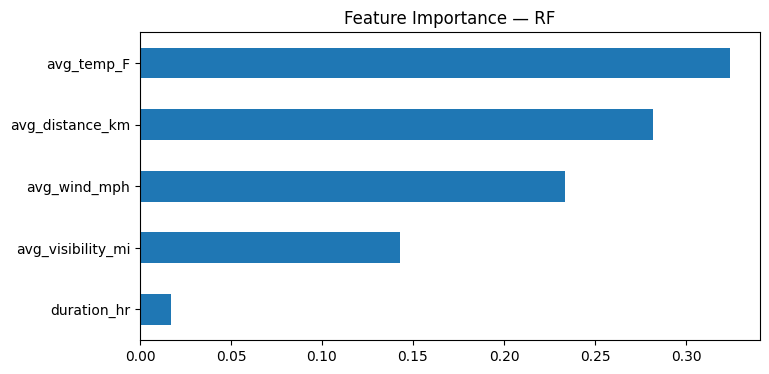

In [4]:

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print("CV AUCs:", np.round(scores,3))
print("Mean:", np.mean(scores), "Std:", np.std(scores))
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8,4))
plt.title('Feature Importance — RF')
plt.show()
y_pred = (y_pred_rf > 0.5).astype(int)
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
mlflow.sklearn.log_model(rf, name="RandomForest_Final", input_example=X_test.iloc[:1])


In [5]:
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

mlflow.set_tracking_uri("siads_699_mads_capstone/mlruns")
mlflow.set_experiment("WorkZone_XGBoost_Final")
X_train_xgb = np.nan_to_num(X_train)
X_test_xgb  = np.nan_to_num(X_test)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    tree_method="hist", 
    n_jobs=-1
)
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train_xgb, y_train)
best_xgb = grid_xgb.best_estimator_
#print("Best XGB params:", grid_xgb.best_params_)

def log_xgb_metrics(model_name, model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    y_pred = (y_pred_proba > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{model_name} AUC={auc_score:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.legend(); plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout()
    base_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
    model_dir = os.path.join(base_dir, "siads_699_mads_capstone","data", "figures")
    os.makedirs(model_dir, exist_ok=True)
    fig_path = os.path.join(model_dir, f"{model_name}_roc.png")
    #fig_path = f"/work/siads_699_mads_capstone/data/models/{model_name}_roc.png"
    plt.savefig(fig_path); plt.close()

    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("F1", f1)
    mlflow.log_artifact(fig_path)
    mlflow.sklearn.log_model(model, name=model_name,
                             input_example=X_test[:1])

    #print(f"{model_name}: AUC={auc_score:.3f}, F1={f1:.3f}")

with mlflow.start_run(run_name="XGBoost_Final"):
    log_xgb_metrics("XGBoost_Final", best_xgb, X_test_xgb, y_test)


Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root

CV AUCs: [0.998 0.999 0.999 1.    0.998]
Mean: 0.9989841848543264 Std: 0.0006787052384356515


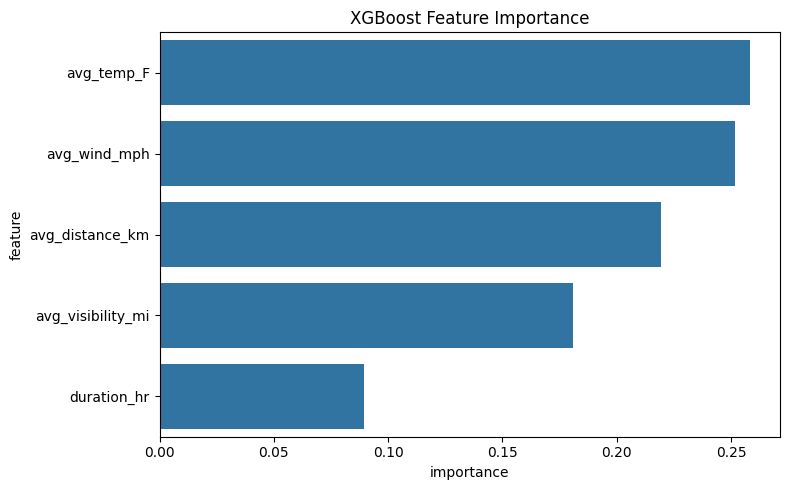

In [6]:
from sklearn.model_selection import cross_val_score
import seaborn as sns

scores = cross_val_score(best_xgb, X_train_xgb, y_train, cv=cv, scoring="roc_auc")
print("CV AUCs:", np.round(scores,3))
print("Mean:", np.mean(scores), "Std:", np.std(scores))

importance = best_xgb.feature_importances_
fi_df = pd.DataFrame({'feature': X_train.columns, 'importance': importance})
fi_df.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=fi_df.head(15))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>